In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Proyecto_Final/Proyecto_Final
!ls -a

Mounted at /content/drive
/content/drive/MyDrive/Proyecto_Final/Proyecto_Final
ColabTrain.ipynb	    .gitignore		pruebaPrecision.ipynb
dataset2		    GMA			README.md
disc-conv.pth		    GUI.py		removeWarped.py
evaluacionResultados.ipynb  .ipynb_checkpoints	warp.py
gen-conv.pth		    libraries.md	weights
generateWarped.py	    NN_resorces
.git			    process_video.py


In [ ]:
ls -a

ColabTrain.ipynb            .gitignore           pruebaPrecision.ipynb
dataset2/                   GMA/                 README.md
disc-conv.pth               GUI.py               removeWarped.py
evaluacionResultados.ipynb  .ipynb_checkpoints/  warp.py
gen-conv.pth                libraries.md         weights/
generateWarped.py           NN_resorces/
.git/                       process_video.py


In [ ]:
import cv2
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
from NN_resorces.Dataset import Dataset
from NN_resorces.UNET import UNET
from NN_resorces.Discriminator import Discriminator
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from os.path import exists
import matplotlib.pyplot as plt
from torch import cat, no_grad, load
import numpy as np

In [ ]:
BATCH = 3
LR = 2e-6
device = "cuda" if cuda.is_available() else "cpu"
dir_dataset = '/content/drive/MyDrive/Proyecto_Final/Proyecto_Final/dataset2'
disc = Discriminator(in_channels=9).to("cuda")
gen = UNET(in_channels=6,channels=[64, 128, 256, 512]).to("cuda")
opt_disc = optim.Adam(disc.parameters(), lr=LR)
opt_gen = optim.Adam(gen.parameters(), lr=LR)
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.MSELoss(reduction='sum')
trainset = Dataset(dir = dir_dataset, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=2)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
if(exists("./weights/disc-conv.pth")):
  disc.load_state_dict(torch.load('./weights/disc-conv.pth'))
  gen.load_state_dict(torch.load('./weights/gen-conv.pth'))

In [ ]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    for data in train_loader:
        (F1,F2,F3) = data
        F1 = F1.to(device)
        F2 = F2.to(device)
        F3 = F3.to(device)
        # Train Discriminator
        with torch.cuda.amp.autocast():
            input = torch.cat([F1, F3], dim=1)
            y_fake = gen(input)
            D_real = disc(input, F2)
            D_real_loss = BCE(D_real, torch.ones_like(D_real))
            D_fake = disc(input, y_fake.detach())
            D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(input, y_fake)
            G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
            L1 = L1_LOSS(y_fake, F2)
            G_loss = G_fake_loss + L1*100
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
    #torch.save(disc.state_dict(), "weights/disc-conv.pth")
    #torch.save(gen.state_dict(), "weights/gen-conv.pth")
    img1 = y_fake.detach().cpu().numpy()[0].transpose(1,2,0)
    img2 = F2.detach().cpu().numpy()[0].transpose(1,2,0)
    f1 = cv2.cvtColor(np.float32(img1), cv2.COLOR_BGR2RGB)
    f2 = cv2.cvtColor(np.float32(img2), cv2.COLOR_BGR2RGB)
    print(epoch)

0
1
2
3
4


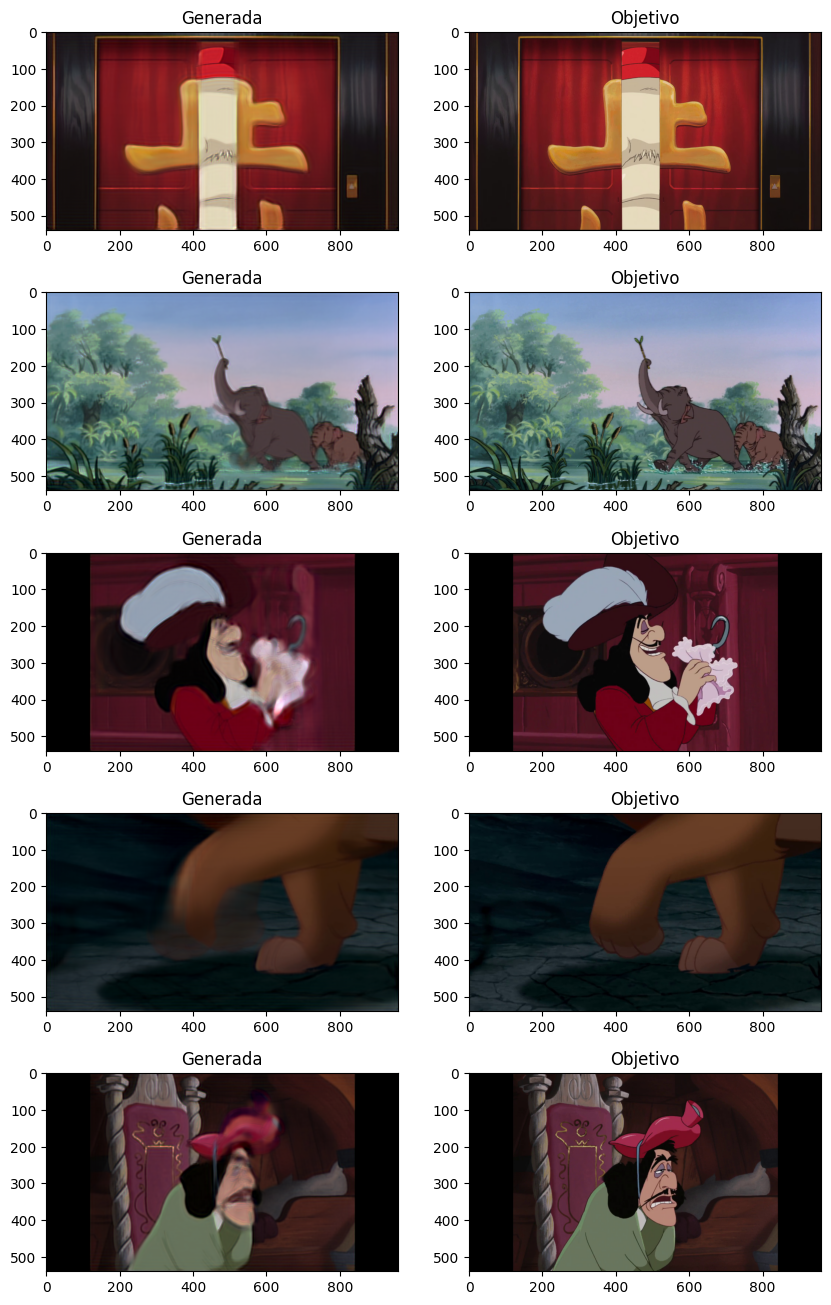

In [ ]:
j = 0
fig = plt.figure(figsize=(10, 40))
for i in range(5):
  data = next(iter(train_loader))
  (F1,F2,F3) = data
  F1 = F1.to(device)
  F2 = F2.to(device)
  F3 = F3.to(device)
  with no_grad():
    input = cat([F1, F3], dim=1)
    output = gen(input).cpu().detach().numpy()[0].transpose(1,2,0)
  img1 = F1.cpu().numpy()[0].transpose(1,2,0)
  img2 = F2.cpu().numpy()[0].transpose(1,2,0)
  img3 = F3.cpu().numpy()[0].transpose(1,2,0)
  del F1,F2,F3
  generated = output
  fNew = cv2.cvtColor(generated, cv2.COLOR_BGR2RGB)
  f2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  fig.add_subplot(12, 2, (1+j))
  plt.imshow(fNew)
  plt.title("Generada")
  fig.add_subplot(12, 2, (2+j))
  plt.imshow(f2)
  plt.title("Objetivo")
  j=j+2

In [ ]:
torch.save(disc.state_dict(), "weights/disc-conv.pth")
torch.save(gen.state_dict(), "weights/gen-conv.pth")